Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
torch.Size([1, 224, 224])


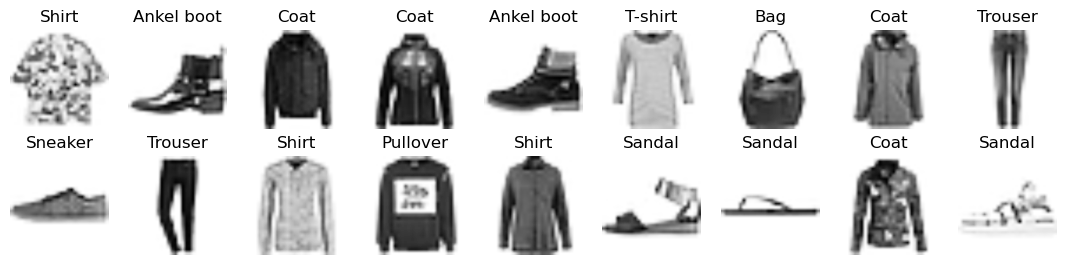

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm

myseed = 1314  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

trans = [transforms.ToTensor()]
trans.insert(0,transforms.Resize(224))
trans = transforms.Compose(trans)
print(trans)
train_data = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=True, transform=trans, download=True)
test_data  = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=False, transform=trans, download=True)
device  = torch.device('cuda' if torch.cuda.is_available else 'cpu')

BATCH_SIZE = 128  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = 50)

class_str = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel boot"]

def get_class(indices):
    return class_str[int(indices)]

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(get_class(label[i]))
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
print(x[0].shape)
show_img(x,y,2,9)

def accuracy(y_pred,y):
    y_pred = y_pred.softmax(1).argmax(1)
    total = y.shape[0]
    right = (y_pred == y).sum()
    print("Acc:%.2f%%"%(right/total*100))
    return (right,total)


def train(train_loader,test_loader,model,n_epoch,lr,device):
    model.to(device)
    optim = torch.optim.SGD(model.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        bar = tqdm(train_loader,total=len(train_loader))
        for x,y in bar:
            optim.zero_grad()
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optim.step()
            bar.set_description(f'Epoch:[{epoch+1:02d}/{n_epoch}]')
            bar.set_postfix(loss=float(loss))
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(device),y.to(device)
                pred = model(x)
                accuracy(pred,y)
                break

In [ ]:
ratio = 4

def vgg_block(conv_nums,in_channels,out_channels):
    layer = nn.Sequential()
    for i in range(conv_nums):
        layer.append(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
        ) 
        layer.append(nn.ReLU())    
        in_channels=out_channels
    layer.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return layer

def vgg(conv_arch):
    conv_block = nn.Sequential()
    in_channels = 1
    for conv_nums, out_channels in conv_arch:
        out_channels = out_channels // ratio
        conv_block.extend(vgg_block(conv_nums,in_channels,out_channels))
        in_channels = out_channels
    fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(p=0.5),
        nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(p=0.5),
        nn.Linear(4096,10)
    )
    conv_block.extend(fc)
    return conv_block


conv_arch = ((1,64),(1,128),(2,256),(2,512),(2,512))
vgg_net = vgg(conv_arch)
x = torch.rand(1,1,224,224)
for layer in vgg_net:
    x = layer(x)
    print("Name: %-10s"%(layer.__class__.__name__),'output shape: ',x.shape)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
vgg_net.apply(init_weights)

In [ ]:
train(train_dataloader,test_dataloader,model=vgg_net,n_epoch=20,lr=0.005,device=device)

In [ ]:
with torch.no_grad():
    vgg_net.eval()
    for x,y in test_dataloader:
        x,y = x.to(device),y.to(device)
        pred = vgg_net(x)
        accuracy(pred,y)
        break

In [2]:
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    block = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
        nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU()
    )
    return block

def nin():
    nin_net = nn.Sequential(
        nin_block(in_channels=1,out_channels=96,kernel_size=11,stride=4,padding=1),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nin_block(in_channels=96,out_channels=256,kernel_size=5,stride=1,padding=2),
        nn.MaxPool2d(kernel_size=3,stride=2),
        nin_block(in_channels=256,out_channels=384,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(kernel_size=3,stride=2),

        nn.Dropout(p=0.5),
        nin_block(in_channels=384,out_channels=10,kernel_size=3,stride=1,padding=1),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten()
    )
    return nin_net

nin_net = nin()
x = torch.rand(1,1,224,224)
for layer in nin_net:
    x = layer(x)
    print("Name: %-10s"%(layer.__class__.__name__),'output shape: ',x.shape)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
nin_net.apply(init_weights)

Name: Sequential output shape:  torch.Size([1, 96, 54, 54])
Name: MaxPool2d  output shape:  torch.Size([1, 96, 26, 26])
Name: Sequential output shape:  torch.Size([1, 256, 26, 26])
Name: MaxPool2d  output shape:  torch.Size([1, 256, 12, 12])
Name: Sequential output shape:  torch.Size([1, 384, 12, 12])
Name: MaxPool2d  output shape:  torch.Size([1, 384, 5, 5])
Name: Dropout    output shape:  torch.Size([1, 384, 5, 5])
Name: Sequential output shape:  torch.Size([1, 10, 5, 5])
Name: AdaptiveAvgPool2d output shape:  torch.Size([1, 10, 1, 1])
Name: Flatten    output shape:  torch.Size([1, 10])


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(ker

In [5]:
train(train_dataloader,test_dataloader,nin_net,10,0.06,device=device)

Epoch:[01/10]: 100%|██████████| 469/469 [00:47<00:00,  9.79it/s, loss=0.494]


Acc:74.00%


Epoch:[02/10]: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s, loss=0.374]


Acc:72.00%


Epoch:[03/10]: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s, loss=0.453]


Acc:74.00%


Epoch:[04/10]: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s, loss=0.467]


Acc:74.00%


Epoch:[05/10]: 100%|██████████| 469/469 [00:47<00:00,  9.81it/s, loss=0.471]


Acc:72.00%


Epoch:[06/10]: 100%|██████████| 469/469 [00:47<00:00,  9.82it/s, loss=0.28] 


Acc:72.00%


Epoch:[07/10]: 100%|██████████| 469/469 [00:47<00:00,  9.80it/s, loss=0.494]


Acc:68.00%


Epoch:[08/10]: 100%|██████████| 469/469 [00:47<00:00,  9.79it/s, loss=0.526]


Acc:74.00%


Epoch:[09/10]: 100%|██████████| 469/469 [00:47<00:00,  9.83it/s, loss=0.431]


Acc:76.00%


Epoch:[10/10]:  25%|██▍       | 115/469 [00:11<00:36,  9.81it/s, loss=0.392]


KeyboardInterrupt: 